# 🎨 Sampling Visualization

You can use this notebook to visualize your trained models.

In [6]:
import sys
sys.path.insert(0, '..')

import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from torchvision.utils import make_grid
from tqdm.notebook import tqdm

plt.style.use('default')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. Load a Trained Model

First, let's load a trained checkpoint. Update the path to your trained model.

In [7]:
import yaml
from src.models import create_model_from_config
from src.methods import DDPM, FlowMatching
from src.utils import EMA

def load_model(checkpoint_path, method='flow_matching'):
    """Load a trained model from checkpoint."""
    print(f"Loading {method} from {checkpoint_path}...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    config = checkpoint['config']

    # 1. Create Model (U-Net)
    model = create_model_from_config(config).to(device)
    model.load_state_dict(checkpoint['model'])

    # 2. Load EMA weights (Crucial for good quality!)
    ema = EMA(model, decay=config['training']['ema_decay'])
    ema.load_state_dict(checkpoint['ema'])
    ema.apply_shadow()  # Swap model weights with EMA weights

    # 3. Instantiate Method Wrapper
    if method == 'ddpm':
        diffusion = DDPM.from_config(model, config, device)
    elif method == 'flow_matching':
        diffusion = FlowMatching.from_config(model, config, device)
    else:
        raise ValueError(f"Unknown method: {method}")

    diffusion.eval_mode()
    return diffusion, config

In [8]:
# ============================================
# UPDATE THIS PATH TO YOUR TRAINED MODEL
# ============================================
CHECKPOINT_PATH = '/home/arnavgoe/10799-Diffusion/cmu-10799-diffusion/logs/reflow_unet_distillation/checkpoints/flow_matching_final.pt'
METHOD = 'flow_matching'  # 'ddpm' or 'flow_matching' or any of your custom method names

import os

if os.path.exists(CHECKPOINT_PATH):
    diffusion, config = load_model(CHECKPOINT_PATH, METHOD)
    
    # Model Stats
    model = diffusion.model
    params = sum(p.numel() for p in model.parameters())
    print(f"\n✓ Loaded Successfully!")
    print(f"  - Parameters: {params:,}")
    print(f"  - Method: {METHOD}")
    print(f"  - Device: {device}")
else:
    print(f"⚠️ Checkpoint not found at: {CHECKPOINT_PATH}")
    print("Please check the path and try again.")

Loading flow_matching from /home/arnavgoe/10799-Diffusion/cmu-10799-diffusion/logs/reflow_unet_distillation/checkpoints/flow_matching_final.pt...

✓ Loaded Successfully!
  - Parameters: 19,851,203
  - Method: flow_matching
  - Device: cuda


In [9]:
# Display model information
def count_parameters(model):
    """Count total and trainable parameters in a model."""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

total_params, trainable_params = count_parameters(model)

print("=" * 60)
print("MODEL INFORMATION")
print("=" * 60)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: {total_params * 4 / (1024**2):.2f} MB (FP32)")
print(f"Method: {METHOD}")
if os.path.exists(CHECKPOINT_PATH):
    print(f"Checkpoint: {CHECKPOINT_PATH}")
else:
    print("Checkpoint: None (untrained model)")
print("=" * 60)

MODEL INFORMATION
Total parameters: 19,851,203
Trainable parameters: 19,851,203
Model size: 75.73 MB (FP32)
Method: flow_matching
Checkpoint: /home/arnavgoe/10799-Diffusion/cmu-10799-diffusion/logs/reflow_unet_distillation/checkpoints/flow_matching_final.pt


This is the model size that I used to get a decently working model (KID around 0.0035, FID around 8). I trained it for around 5 hours on 4 L40S GPUs. I don't think you need 4 GPUs for this model, I have later trained the same model on a single L40S GPU and it was also able to work decently well after roughly the same amount of time (KID around 0.0039), I think you can probably train this model on a single L40S GPU for even shorter and still get a ok model (but this is not an excuse for you to procrastinate on starting the homework! Start early so that you have enough time to debug!!)

## 2. DDPM Sampling

The standard DDPM sampling algorithm iteratively denoises from pure noise. I have included a grid sampled from the model that I showed above for your reference here.

Sampling 16 images using flow_matching (10 steps)...


Flow Matching Sampling: 100%|██████████| 10/10 [00:00<00:00, 58.27it/s]


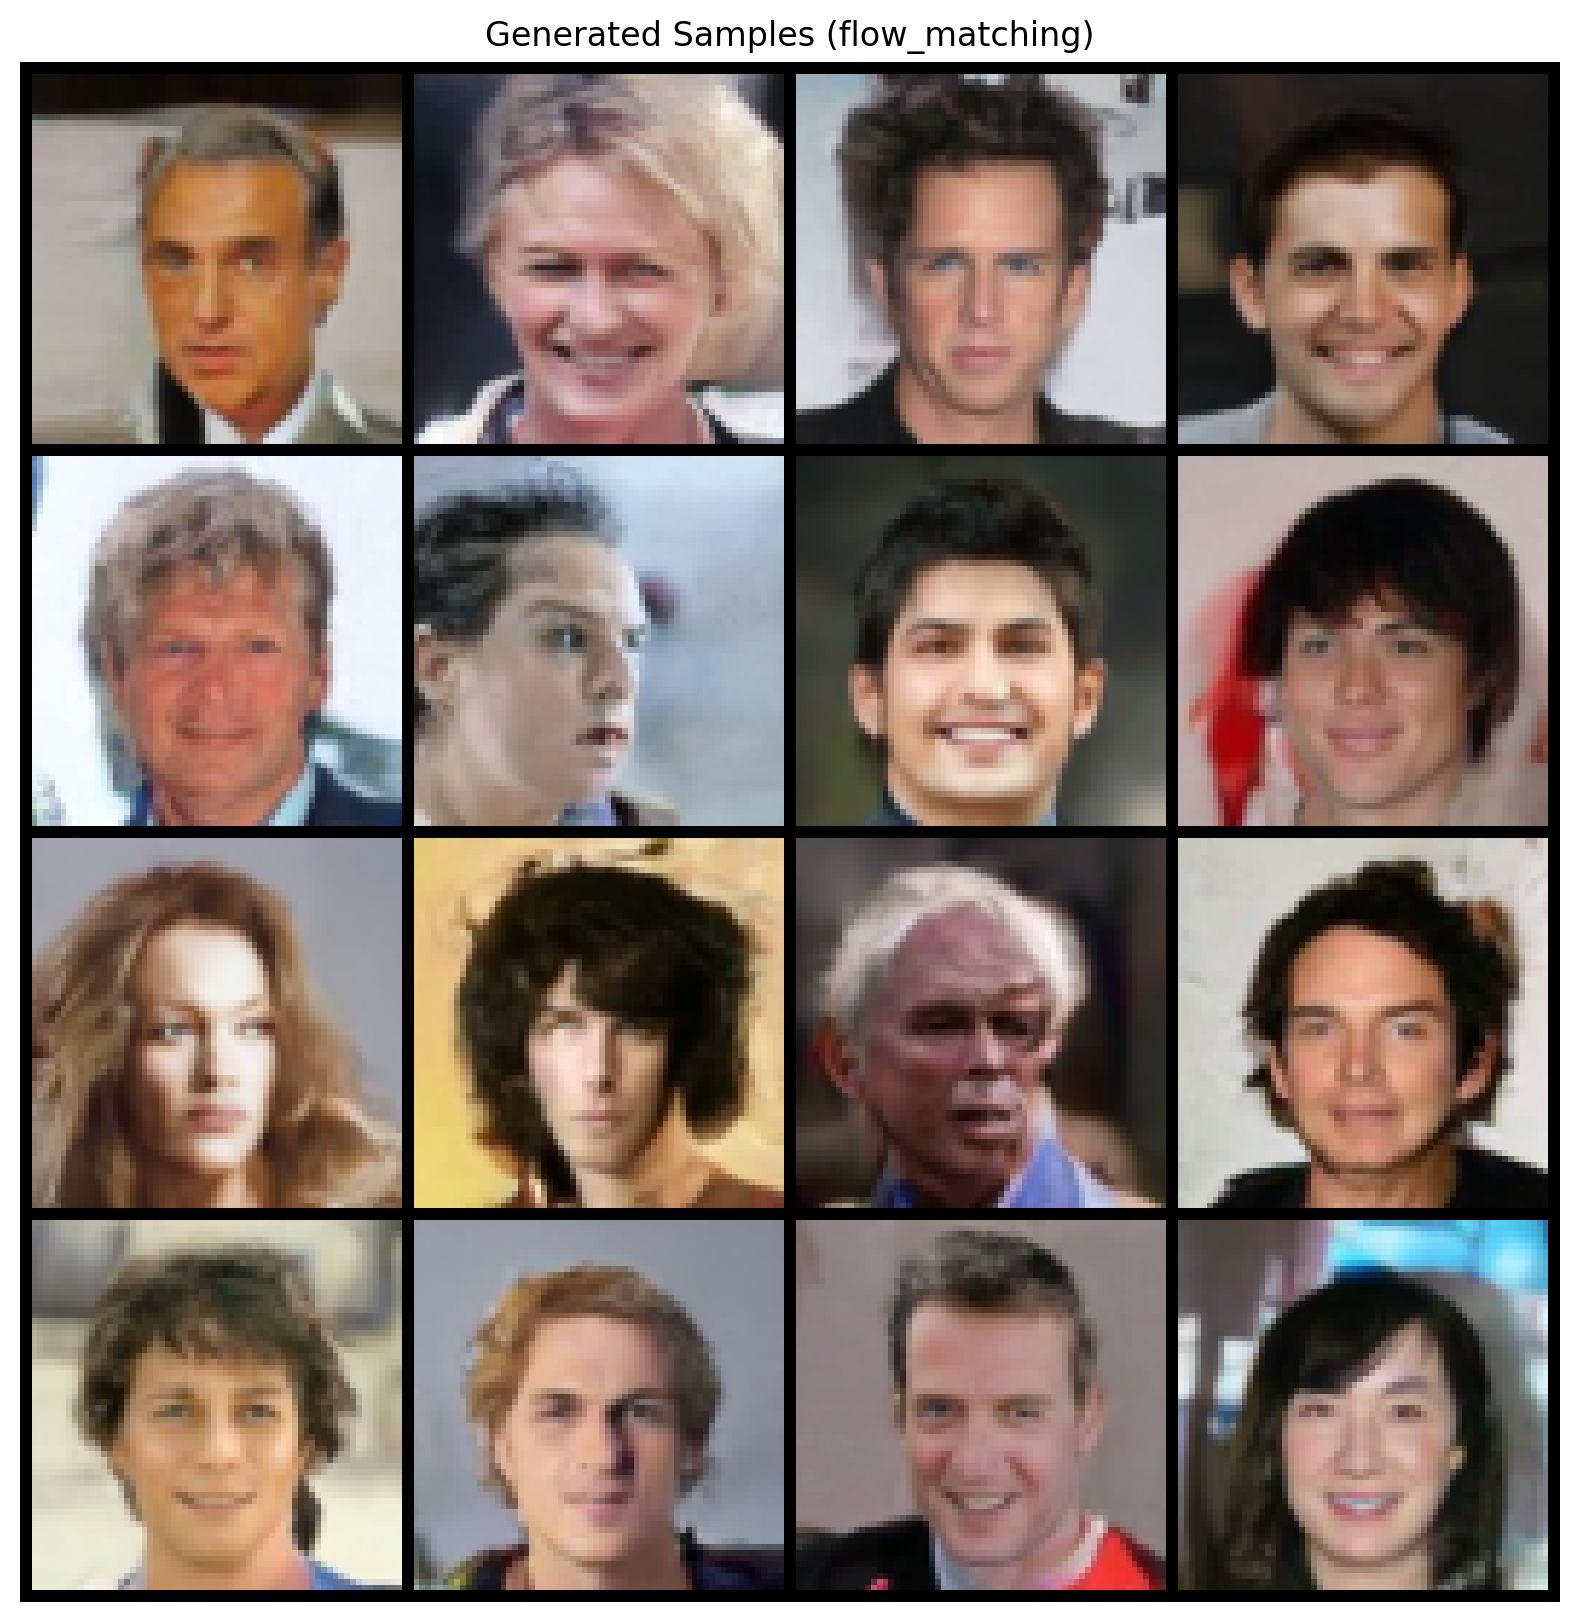

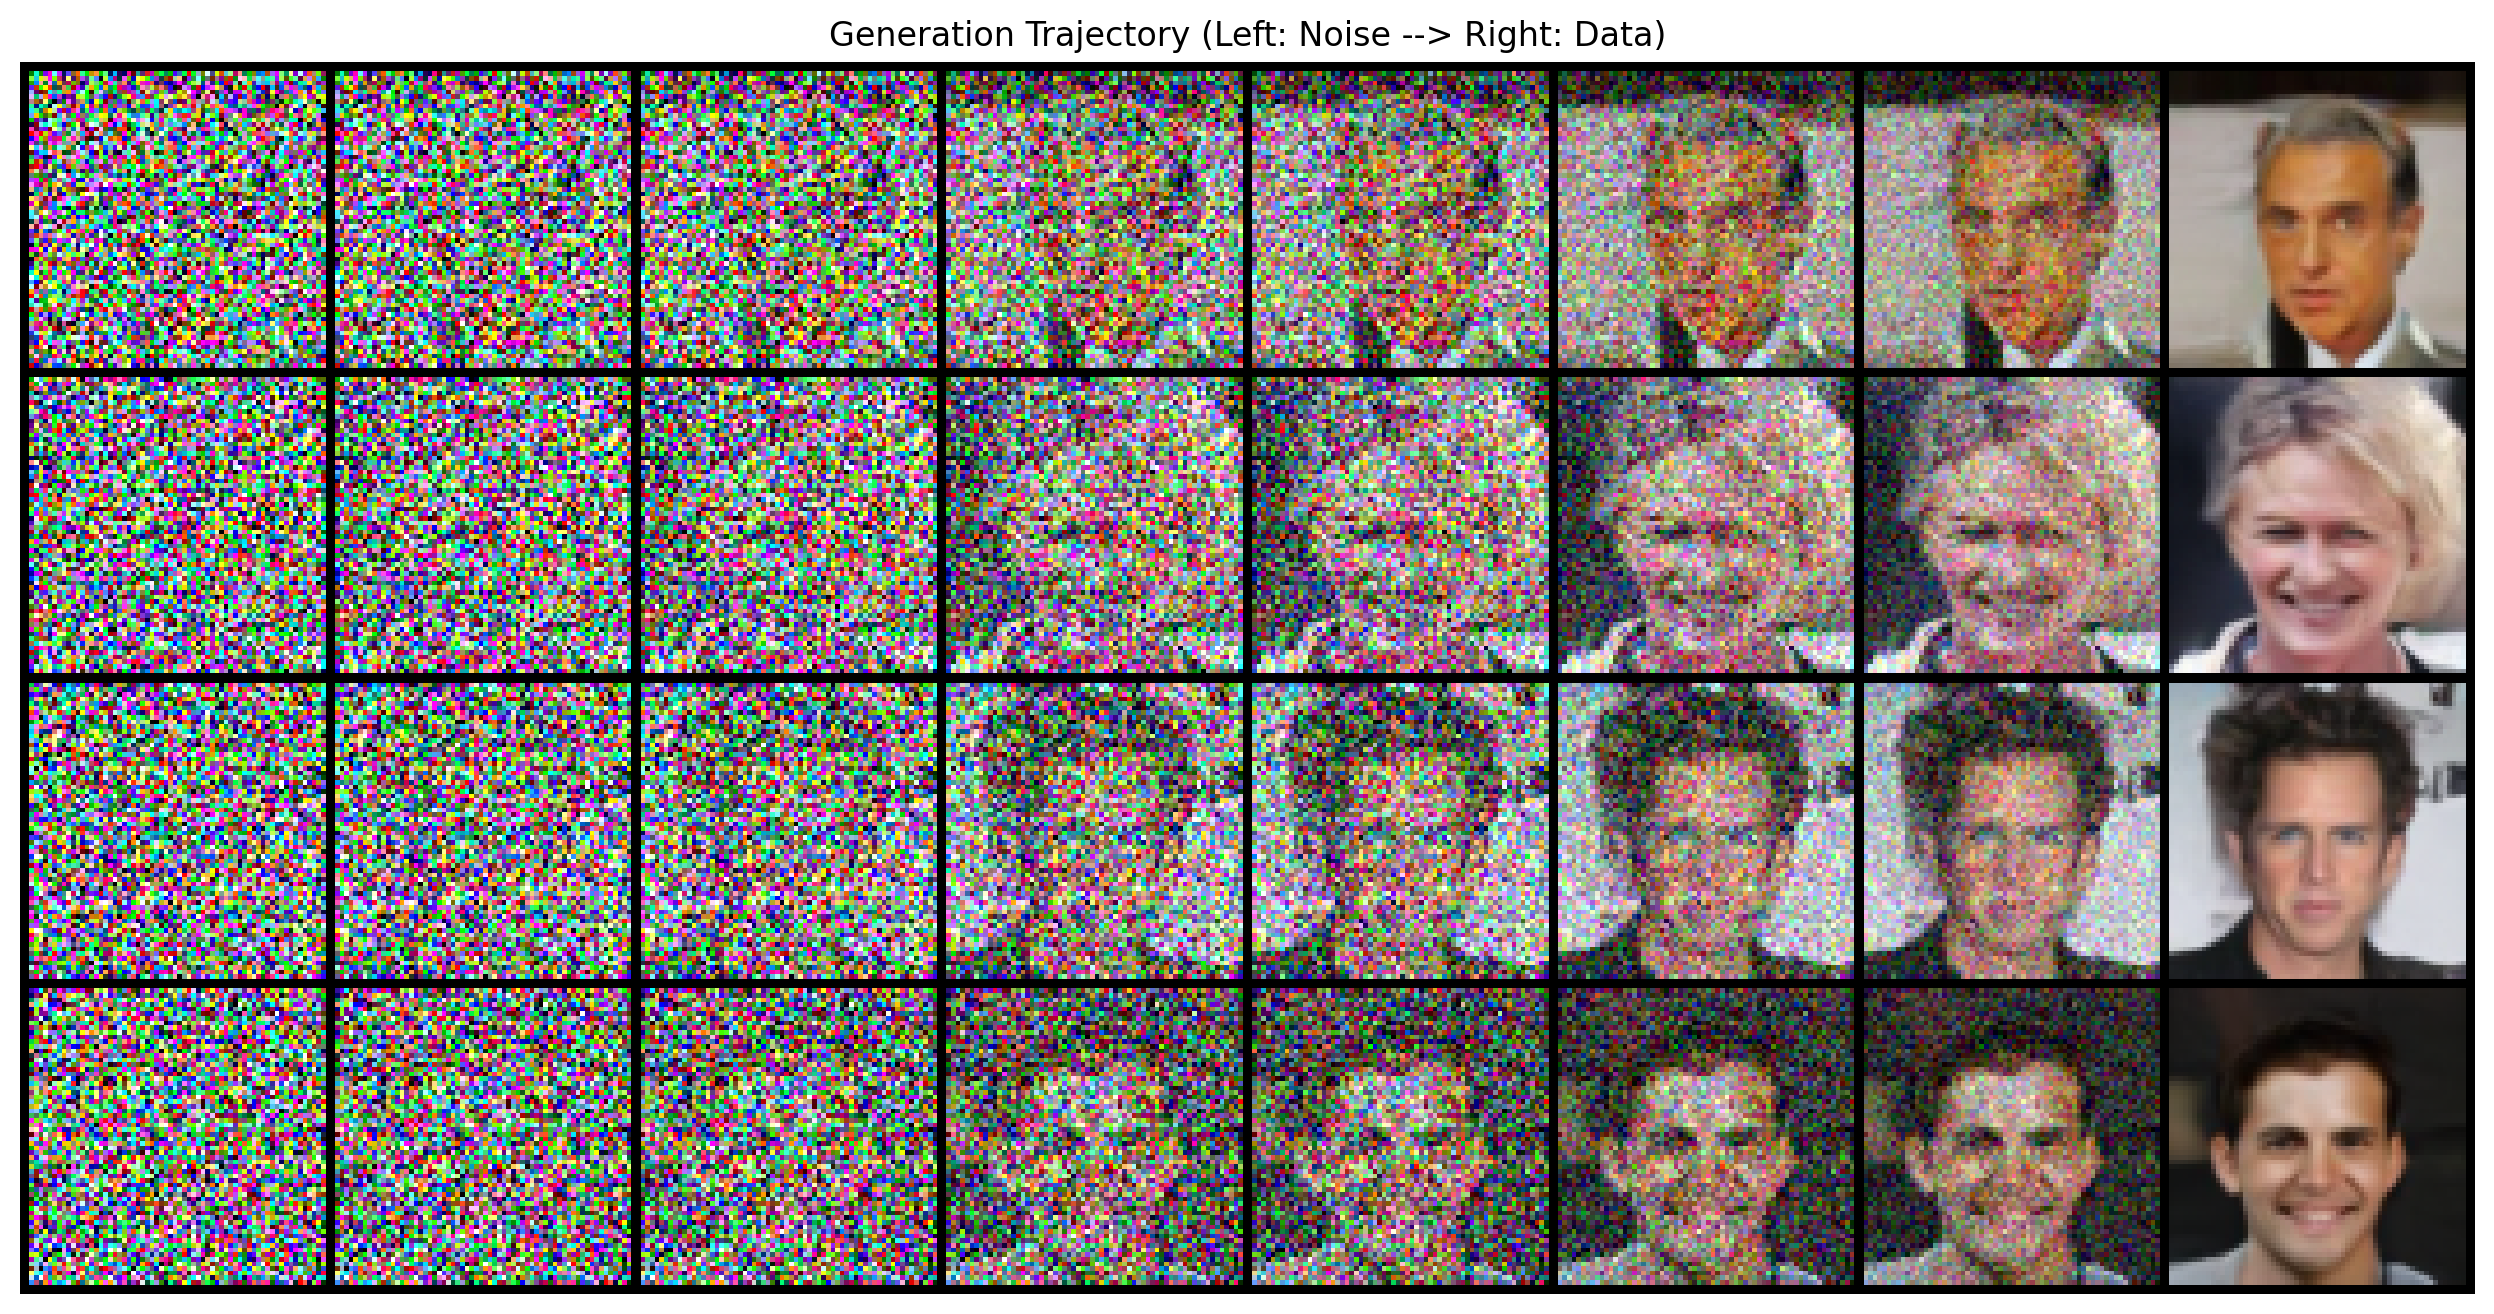

In [10]:
# -----------------------------------------------------------------------------
# 1. Configuration
# -----------------------------------------------------------------------------
num_samples = 16
image_shape = (3, 64, 64)

# Flow Matching works great with fewer steps!
# 100 is usually perfect. DDPM needs 1000.
# num_steps = 100 if METHOD == 'flow_matching' else 1000
num_steps = 10 if METHOD == 'flow_matching' else 1000

print(f"Sampling {num_samples} images using {METHOD} ({num_steps} steps)...")

# -----------------------------------------------------------------------------
# 2. Run Sampling
# -----------------------------------------------------------------------------
diffusion.to(device)

with torch.no_grad():
    # Returns list of tensors: [x_start, ..., x_end]
    # For Flow Matching: x_start is Noise, x_end is Data
    history = diffusion.sample(
        batch_size=num_samples,
        image_shape=image_shape,
        verbose=True,
        num_steps=num_steps
    )

# Stack into one big tensor: (TimeSteps, Batch, C, H, W)
trajectory = torch.stack(history)

# -----------------------------------------------------------------------------
# 3. Visualize Final Grid
# -----------------------------------------------------------------------------
def unnormalize_to_zero_one(t):
    # Assumes data was normalized to [-1, 1] during training
    return (t + 1) * 0.5

# Get the final step (Data)
final_samples = trajectory[-1].cpu()
final_samples = unnormalize_to_zero_one(final_samples).clamp(0, 1)

plt.figure(figsize=(10, 10))
plt.title(f"Generated Samples ({METHOD})")
final_grid = make_grid(final_samples, nrow=4, padding=2)
plt.imshow(final_grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

# -----------------------------------------------------------------------------
# 4. Visualize Trajectories (Evolution)
# -----------------------------------------------------------------------------
# Show evolution for the first few samples
num_show_samples = 4
num_time_steps_to_show = 8

# Select evenly spaced time indices
time_indices = torch.linspace(0, len(trajectory) - 1, num_time_steps_to_show).long()

traj_images = []
for i in range(num_show_samples):
    for t in time_indices:
        img = trajectory[t, i].cpu()
        traj_images.append(img)

traj_tensor = torch.stack(traj_images)
traj_tensor = unnormalize_to_zero_one(traj_tensor).clamp(0, 1)

plt.figure(figsize=(16, 8))
plt.title(f"Generation Trajectory (Left: Noise --> Right: Data)")
# nrow=num_time_steps_to_show creates rows of evolution
traj_grid = make_grid(traj_tensor, nrow=num_time_steps_to_show, padding=2)
plt.imshow(traj_grid.permute(1, 2, 0))
plt.axis('off')
plt.show()